## Data Challenge:Analysis of ALS-FRS user data and prediction of its progress in future

- The Data set 1: time series analysis of ALS-FRS is applied for this analysis.
- The files include "user_ALSFRS_score.csv" and "user_onset_date.csv"

### Packages and Libraries 

In [1]:

import os 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

#libraries for date time conversion 
from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore') # to supress the warnings message

### Feature exploration and visualization to understand the data set 

In [2]:
df1=pd.read_csv('user_ALSFRS_score.csv', index_col=0)
df1.head()

,user_id,report_date,score
0,2520,2005-08-05,36
1,2520,2002-01-04,44
2,2520,2006-12-08,28
3,2520,2006-08-04,29
4,2520,2007-04-13,29


In [3]:
df1.shape

(4409, 3)

In [4]:
df1.isnull().sum()

user_id        0
report_date    0
score          0
dtype: int64

In [5]:
for column in df1:
    unique_vals=np.unique(df1[column])
    nr_values=len(unique_vals)
    if nr_values<10:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature user_id :200
The number of values for feature report_date :2893
The number of values for feature score :49


In [6]:
df1.user_id.unique()

array([2520,  147,  217, 1361,  436, 6900, 6728, 5085, 1200, 4561, 6492,
       5081, 4322,  788, 5636,  782, 6654, 3327,  184, 5526,   43, 2917,
       7344, 5009, 4956, 6161, 4281, 2703, 6436, 3679, 2128,  985, 5450,
       3518, 6562,  525, 6813, 1816,  193, 5379, 1057, 5489, 1097, 4236,
       1702, 5765, 4941,  890,  733, 1189, 7263, 1821, 7087, 5212, 4417,
        526, 3624, 4952,  350, 5283, 3893, 1914, 3725, 5814, 2281, 3761,
       1229,  417, 2416, 1865, 3880, 3873, 4707, 3887, 6923, 3719, 4053,
       5594, 6452, 6272, 6643, 6705, 4156, 2859, 3789, 7318, 3055, 4161,
        800, 4742,  811, 3805, 3439, 6788, 7188, 3948, 2272, 1992, 6628,
       1171,  521,  588, 3806, 1960, 1206,  468, 5052, 4887, 3995,  997,
       5993, 5173,  724,  304, 5366,  792,  288, 6797, 3507, 5487, 3895,
       5236, 5828, 1991, 3858, 5692, 1425,  730,   75, 7233, 5820, 5557,
       2050,  108, 1256, 1010, 5011, 2019, 5807, 2856, 2133, 4427, 3550,
       4132, 2077, 7423,  509, 6276,  205,  544, 29

In [7]:
df1.dtypes

user_id         int64
report_date    object
score           int64
dtype: object

### @Comments 
- The first csv file has no null values <br>
- The 'record_date' in object dtype and 'score' is in int64 for an individual user_id<br>
- No cleaning or removing missing value method is applied

### One set of user_id is randomly selected and is analysed to get a feel of the data structure 

In [8]:
df1_2520=df1[df1.user_id==2520]
df1_2520.head()

,user_id,report_date,score
0,2520,2005-08-05,36
1,2520,2002-01-04,44
2,2520,2006-12-08,28
3,2520,2006-08-04,29
4,2520,2007-04-13,29


In [9]:
df1_2520.report_date.max()

'2017-08-02'

In [10]:
df1_2520.report_date.min()

'1997-03-01'

### Loading the other csv file 'user_onset_date.csv" 

In [11]:
df2=pd.read_csv('user_onset_date.csv',index_col=0)

In [12]:
df2.head()

,user_id,first_definitive_diagnosis_date
0,4941,2008-01-01
1,5814,2004-06-01
2,6161,2007-03-01
3,1702,2006-02-01
4,43,1999-08-01


In [13]:
df2.shape

(229, 2)

In [14]:
df2.user_id.unique()

array([4941, 5814, 6161, 1702,   43, 6643, 3789, 3805,  193,  800, 6562,
        184, 7188, 5283,  526, 3893, 2703, 4161, 5450, 5085, 4281,  788,
       1097,  147,  733, 5009,  811, 4952, 2917, 6923, 4236, 3518, 5765,
       5526, 1914,  350, 1057, 7344, 3439,  525, 2281, 3761, 5379, 3873,
       7087, 2128, 5489, 6436, 2520, 4417,  985,  890, 3880, 5594, 7263,
       1865, 2272, 1200, 5081, 3948, 1229, 4956,  436, 6705, 6452, 6492,
       3725,  782, 1821,  217, 6900, 3887, 3327, 6272, 1189, 2859, 3055,
       1361, 3719, 4322, 1816, 6813, 5636, 4707, 1992, 6628, 1171,  588,
        521, 3806, 1960, 1206,  468, 4887, 3995,  997, 5993, 5173,  724,
        304,  792,  288, 6797, 3507, 5366, 5236, 5828, 1991, 3858, 5692,
       1425,  730,   75, 7233, 5557, 2050,  108, 1256, 1010, 5011, 2019,
       5807, 2856, 2133, 4427, 4132, 2077, 7423, 3550, 6276,  205,  544,
       5820, 2909, 2768, 6176, 3777, 4237, 3028, 7150, 5706, 6061, 1721,
       5245, 6180, 1891, 5272, 2811, 5141,  163, 20

### Getting a correlation between the two csv file.  

In [15]:
df2.loc[df2['user_id'] == 2520,'first_definitive_diagnosis_date']

48    2000-12-18
Name: first_definitive_diagnosis_date, dtype: object

In [16]:
df1_2520['report_date'] = pd.to_datetime(df1_2520['report_date'])
df1_2520['report_date'] =df1_2520['report_date'].dt.year

<function matplotlib.pyplot.show(close=None, block=None)>

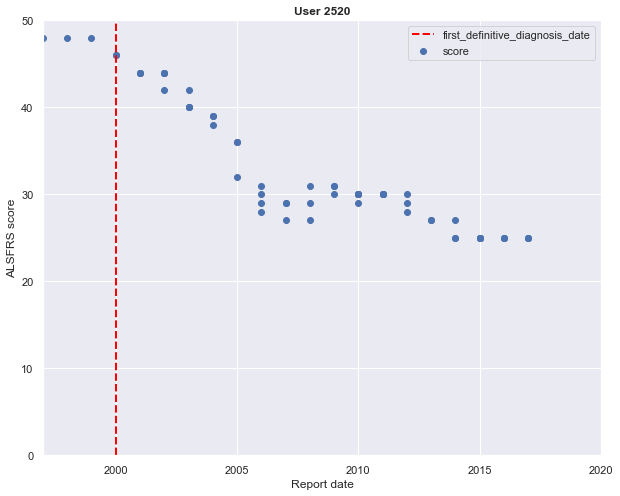

In [17]:
#fig,ax = plt.subplots()
plt.figure(figsize=(10, 8))
plt.title('User 2520', fontsize=12,fontweight='bold')

plt.scatter(data=df1_2520,x='report_date',y='score')
plt.axvline(2000, color='red', linestyle='dashed', linewidth=2,label='first_definitive_diagnosis_date')
plt.xlim(1997,2020)
plt.ylim(0,50)
plt.xlabel("Report date")
plt.ylabel('ALSFRS score')
plt.legend()
plt.show



In [18]:
df1_2520.shape

(62, 3)

In [19]:
df1_2520.dtypes

user_id        int64
report_date    int64
score          int64
dtype: object

### @Comments 
- The two csv file have different number of user_id. 
- It will be good to compare and know which of the user_id are missing in the two csv file

**Questions which oriented to work on building the Machine Learning tool**
    
- How important it is to know the "first definitive diagnosis data of user"? 
- What are the information available for the data points visible before the "first definitive diagnosis data of user"?
- Are they not definitive? then how were they recorded?

### Analyse other user_ids to get more insight of the first csv file

In [20]:
df1_5081=df1[df1.user_id==5081]
len(df1_5081)

29

In [21]:
df1_5081.report_date.max()

'2008-12-29'

In [22]:
df1_5081.report_date.min()

'2004-07-01'

In [23]:
df2.dtypes

user_id                             int64
first_definitive_diagnosis_date    object
dtype: object

In [24]:
df2.loc[df2['user_id'] == 5081,'first_definitive_diagnosis_date']

58    2007-11-01
Name: first_definitive_diagnosis_date, dtype: object

In [25]:
df1_5081['report_date'] = pd.to_datetime(df1_5081['report_date'])
df1_5081['report_date'] =df1_5081['report_date'].dt.year

<function matplotlib.pyplot.show(close=None, block=None)>

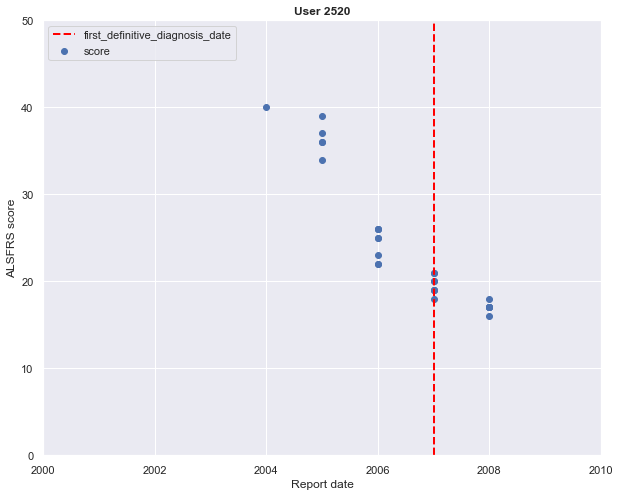

In [26]:
#fig,ax = plt.subplots()
plt.figure(figsize=(10, 8))
plt.title('User 2520', fontsize=12,fontweight='bold')

plt.scatter(data=df1_5081,x='report_date',y='score')
plt.axvline(2007, color='red', linestyle='dashed', linewidth=2,label='first_definitive_diagnosis_date')
plt.xlim(2000,2010)
plt.ylim(0,50)
plt.xlabel("Report date")
plt.ylabel('ALSFRS score')
plt.legend()
plt.show



In [27]:
df1_count=df1.groupby(['user_id']).count()

In [28]:
df1_count.head()

,report_date,score
user_id,,
43,16,16
75,19,19
108,12,12
147,14,14
163,13,13


In [29]:
df1_count['score'].max()

78

In [30]:
df1_count['score'].min()

11

### @Comments 
- The data points for each user_id are not the same
- The start and the end date for data collection for each user are also not consistant
- To have an uninformity for each user more informations are required
- Considered working on building a time series analysis for a single user having a considerable amount of data

### Machine Learning tool to predict the ALS-FRS progressing in the future for a singe user 
- The aim to build an appropriate model for data poitns for a single user and then we can impliment for all users
- Since each user is different, more insights on the user e.g age, sex etc. will be helpful for a universal model implication
- Researched on an appropriate time series model e.g (https://www.frontiersin.org/articles/10.3389/fdata.2020.00004/full)
- Autoregressive integrated moving average (ARIMA), a multilayer perceptron (MLP) model, a long short-term memory (LSTM) model were suggested
- ARIMA model is randomly selected 
- The proper selection of model needs to be studied

In [31]:
#Getting back to dataframe created earlier in the code for user_id 2520 to implement the ARIMA model

In [32]:
# Changing the time to date -  Time Series Models require date structure
df1_2520['report_date'] = df1_2520['report_date'].astype(str) 
df1_2520['report_date'] = pd.to_datetime(df1['report_date'])

In [33]:
# Splittitng the data to train and valid set with 75%:25% ratio respectively
# The data from the first definitive diagnosis is assumed to be be reliable
# The data is splitted to train and  valid starting from the first definitive diagnosis for user_id 2520 i.e 2000

X_train = df1_2520.loc[(df1['report_date'] > '2000') & (df1_2520['report_date'] < '2014')]
X_valid = df1_2520.loc[df1_2520['report_date'] >= '2013']

print('X_train Shape', X_train.shape)
print('X_valid Shape', X_valid.shape)

X_train Shape (46, 3)
X_valid Shape (15, 3)


### Running Arima (Autoregressive Integrated Moving Average) - for one User with user_id 2520
ARIMA:

Uses a number of lagged observations of time series to forecast observations
Inputs / Parameters:

p: the number of lag observations in the model; also known as the lag order (AR) 
d: the number of times that the raw observations are differenced; also known as the degree of differencing (I)
q: the size of the moving average window; also known as the order of the moving average (MA) 

In [34]:
# filtering the train data
user_2520_t = X_train[X_train['user_id'] == 2520]
user_2520_train = user_2520_t[['report_date', 'score']]

#filtering the valid data
user_2520_v = X_valid[X_valid['user_id'] == 2520]
user_2520_valid= user_2520_v[['report_date', 'score']]

In [35]:
# set the date into index
user_2520_train.set_index('report_date', inplace=True)
user_2520_valid.set_index('report_date', inplace=True)

# Setting the Index for 15 dates starting from the end of the training date to end of the data points

index_ = pd.date_range(start= '2013-04-30', end='2017-07-31', periods=15) #str or DateOffset,year start frequency

index_

DatetimeIndex([          '2013-04-30 00:00:00',
               '2013-08-18 22:17:08.571428572',
               '2013-12-07 20:34:17.142857144',
               '2014-03-28 18:51:25.714285716',
               '2014-07-17 17:08:34.285714288',
               '2014-11-05 15:25:42.857142864',
               '2015-02-24 13:42:51.428571432',
                         '2015-06-15 12:00:00',
               '2015-10-04 10:17:08.571428576',
               '2016-01-23 08:34:17.142857152',
               '2016-05-13 06:51:25.714285728',
               '2016-09-01 05:08:34.285714288',
               '2016-12-21 03:25:42.857142864',
               '2017-04-11 01:42:51.428571440',
                         '2017-07-31 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [36]:
# Running ARIMA with random numbers
model_arima = ARIMA(user_2520_train, order=(4,2,1)) # start 2-0-0 and move to the best
model_arima_fit = model_arima.fit(disp=-1)

# Saving ARIMA predictions
fcast1 = model_arima_fit.forecast(15)[0]

# Passing the same index as the others
fcast1 = pd.Series(fcast1, index=index_)
fcast1 = fcast1.rename("Arima") 


<AxesSubplot:title={'center':'User-1'}, xlabel='report_date', ylabel='score'>

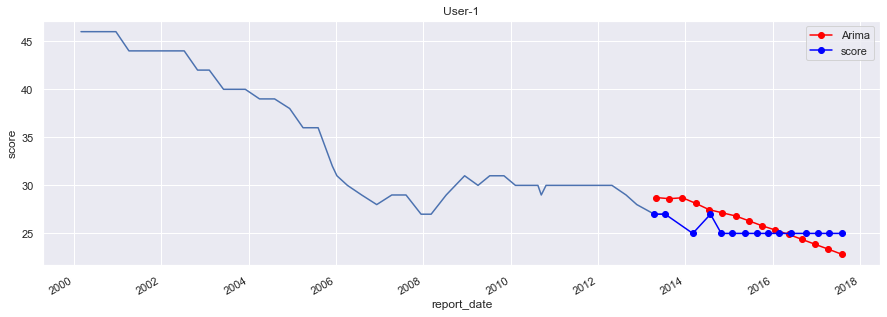

In [37]:
# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='report_date', y='score', data = user_2520_t)
chart.set_title('User-1')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
user_2520_valid.plot(ax=ax, color='blue', marker="o", legend=True)

In [38]:
# Printing the AI
print('The MSE of ARIMA is:', mean_squared_error(user_2520_v['score'].values, fcast1.values, squared=False))

The MSE of ARIMA is: 1.8452504052951748


### @Comments
- The p,d,q are the important parameter for ARIMA model (https://otexts.com/fpp3/non-seasonal-arima.html)
- Here two options are tried to get the values 
        Option1: Manual and Option 
        Option2: Autocorrelation method

In [39]:
###### Option 1: Finding the best value for ARIMA

import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima = ARIMA(user_2520_train,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    
#The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
#statistical models for a given set of data

#It's like the mean squared error in Regression - The smaller the number, the better

(0, 0, 0) 303.9954161271369
(0, 0, 1) 285.6782181638871
(0, 0, 2) 286.0645527615111
(0, 0, 3) 287.0222408915581
(0, 0, 4) 286.46765591134897
(0, 1, 0) 283.30857853351444
(0, 1, 1) 280.37848268115283
(0, 1, 2) 277.8820350028082
(0, 1, 3) 279.62100758026924
(0, 1, 4) 281.60470592228427
(0, 2, 0) 315.29981774646683
(0, 2, 1) 283.884255856986
(0, 2, 2) 282.2177249718709
(0, 2, 3) 280.05465292436105
(0, 2, 4) 281.6832126187416
(1, 0, 0) 282.2037335626138
(1, 0, 1) 284.18498422838036
(1, 0, 4) 286.39754304566736
(1, 1, 0) 283.58193331349514
(1, 1, 1) 287.30857311086163
(1, 1, 2) 279.6231883846938
(1, 1, 3) 283.8257310204891
(1, 1, 4) 285.0486788691227
(1, 2, 0) 308.49521028125037
(1, 2, 1) 284.5430349832075
(1, 2, 3) 281.72487268925033
(2, 0, 0) 284.2012638898945
(2, 0, 1) 285.206675742629
(2, 0, 2) 284.9782876762008
(2, 0, 3) 286.5108815745833
(2, 0, 4) 288.5569678792887
(2, 1, 0) 277.8788800040581
(2, 1, 1) 279.24516330420926
(2, 1, 2) 281.6155458223218
(2, 1, 3) 282.56345467466446
(2, 2, 

In [40]:
#Option2 get value of pqd from autocorrelation
from pandas.plotting import autocorrelation_plot


In [41]:
df1_pqd=df1_2520.drop(columns=['user_id'],axis=1)

In [42]:
df1_pqd=df1_pqd.set_index('report_date')

In [43]:
df1_pqd.head()

,score
report_date,
2005-08-05,36
2002-01-04,44
2006-12-08,28
2006-08-04,29
2007-04-13,29


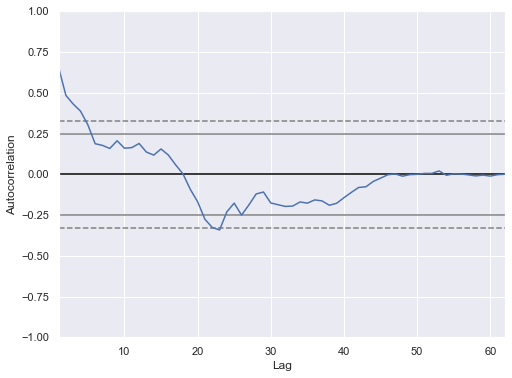

In [44]:
autocorrelation_plot(df1_pqd)
plt.grid()
plt.show()
# p value can be 4 or 5

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf

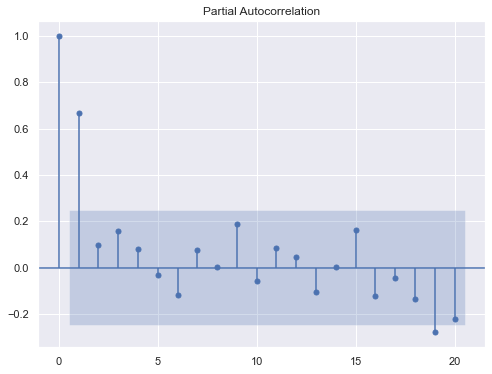

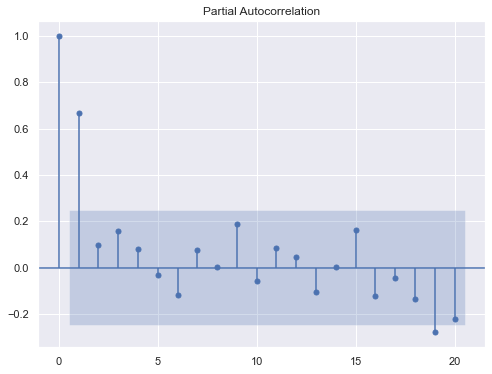

In [46]:
plot_pacf(df1_pqd,lags=20)
#q value is 2
#d value can be 1 or 2

### Future predictions
- Starting from the end date of the data points, 15 dates (next 4 years) and hence the index is created
- The ARIMA model is implemented but with tunned in hyperparameter to predict the future score values

In [47]:
# filtering the train data
user_2520_t= X_train[X_train['user_id'] == 2520]
user_2520_t2 = user_2520_t[['report_date', 'score']]

#filtering the valid data
user_2520_v = X_valid[X_valid['user_id'] == 2520]
user_2520_v2= user_2520_v[['report_date', 'score']]

In [48]:
# set the date into index
user_2520_t2.set_index('report_date', inplace=True)
user_2520_v2.set_index('report_date', inplace=True)

In [49]:
 # all data
all_data = df1_2520[df1_2520['user_id']==2520]
all_data2 = all_data[['report_date', 'score']]
all_data2.set_index('report_date', inplace=True)

In [50]:
   # Setting the Future - Index for 15 days
f_index_ = pd.date_range(start='2017-07-31', end= '2021-06-30', periods = 15) 
  

In [51]:
f_index_

DatetimeIndex([          '2017-07-31 00:00:00',
               '2017-11-10 03:25:42.857142857',
               '2018-02-20 06:51:25.714285714',
               '2018-06-02 10:17:08.571428572',
               '2018-09-12 13:42:51.428571428',
               '2018-12-23 17:08:34.285714288',
               '2019-04-04 20:34:17.142857144',
                         '2019-07-16 00:00:00',
               '2019-10-26 03:25:42.857142856',
               '2020-02-05 06:51:25.714285712',
               '2020-05-17 10:17:08.571428576',
               '2020-08-27 13:42:51.428571424',
               '2020-12-07 17:08:34.285714288',
               '2021-03-19 20:34:17.142857136',
                         '2021-06-30 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [52]:
# Running ARIMA with random numbers
model_arima = ARIMA(all_data2, order=(3,1,2)) # start 2-0-0 and move to the best
model_arima_fit = model_arima.fit(disp=-1)

# Saving ARIMA predictions
f_fcast1 = model_arima_fit.forecast(15)[0]

# Passing the same index as the others
f_fcast1 = pd.Series(f_fcast1, index=f_index_)
f_fcast1 = f_fcast1.rename("Future - Arima") 

<AxesSubplot:title={'center':'User-1'}, xlabel='report_date', ylabel='score'>

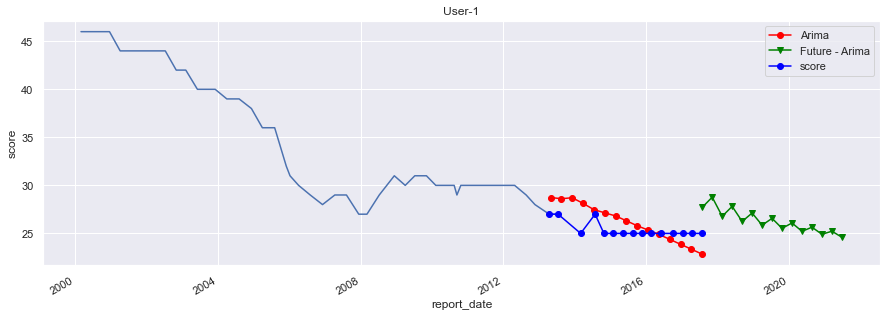

In [53]:
# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='report_date', y='score', data = user_2520_t)
chart.set_title('User-1')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
f_fcast1.plot(ax=ax, color='green', marker="v", legend=True)
user_2520_valid.plot(ax=ax, color='blue', marker="o", legend=True)

### Conclusions
- The validation data points has a MSE of 1.8 so the difference in the real values and the predicted value is ~2
- The future prediction of the scores looks consistant
- The model options should be analysed 
- The model should be tested for all users and get a trend of progressive speed of the individual user which we get from the slop of the curve



### Future work 
- The user_id can be grouped by the age, sex
- Implement the trend of progressive speed of the individual user in the model 
- Creat a more generic code where all the users can be included
- The data points can be interpolated or extrapolated to be consistant with other user (need more insights on this)
